In [5]:
import numpy as np

X_train = np.load('../Our_Saved/X_train.npy')
X_test = np.load('../Our_Saved/X_test.npy')
y_train = np.load('../Our_Saved/y_train.npy')
y_test = np.load('../Our_Saved/y_test.npy')

In [7]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(18, 500, 3)
(6, 500, 3)
(18,)
(6,)


In [12]:
x_train=np.hstack((X_train[:,:,0],X_train[:,:,1],X_train[:,:,2]))
x_test=np.hstack((X_test[:,:,0],X_test[:,:,1],X_test[:,:,2]))

print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

x_train: (18, 1500)
x_test: (6, 1500)
y_train: (18,)
y_test: (6,)


In [8]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}


Test Case 1 (LAYING):
Predicted label: 4
True label: 6
--------------------------------------------------
Test Case 2 (SITTING):
Predicted label: 4
True label: 4
--------------------------------------------------
Test Case 3 (STANDING):
Predicted label: 4
True label: 5
--------------------------------------------------
Test Case 4 (WALKING):
Predicted label: 2
True label: 1
--------------------------------------------------
Rate limit error: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}. Retrying in 10 seconds...
Rate limit error: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}. Retrying in 10 seconds...
Test Case 5 (WALKING_DOWNSTAIRS):
Predicted label: 2
True label: 3
--------------------------------------------------
Test Case 6 (WALKING_UPSTAIRS):
Predicted label: 4
True label: 2
--------------------------------------------------
Accuracy: 0.17


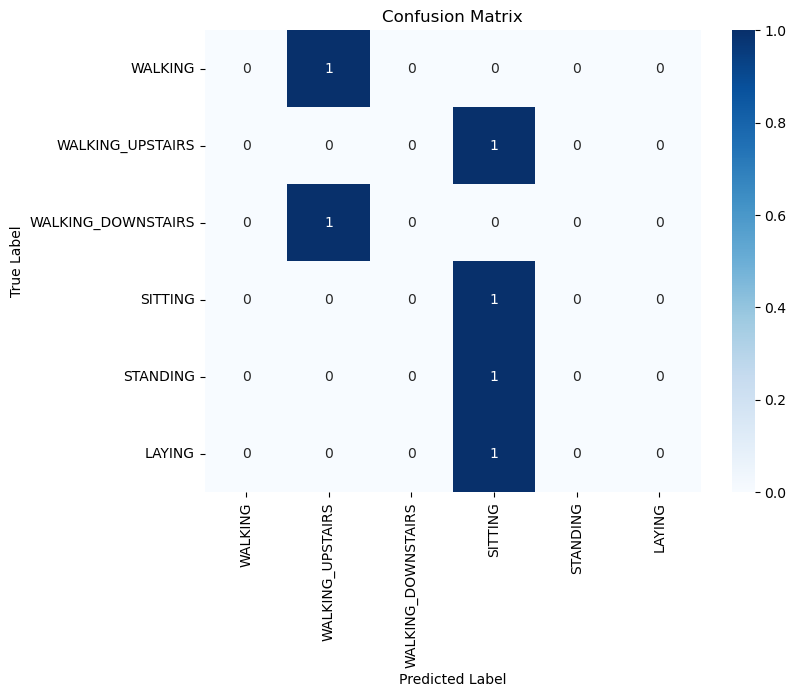

In [16]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train = X_train[:,:300]
X_test = X_test[:,:300]
# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 1
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a 1x1500 vector containing numerical values that represent transformed features.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 1
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
